In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from scipy import stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
# automap documentation - https://docs.sqlalchemy.org/en/13/orm/extensions/automap.html
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
tables = Base.classes.keys()
tables

['measurement', 'station']

In [8]:
# Get column names and data types for each table
inspector = inspect(engine)
for table in tables:
    columns = inspector.get_columns(table)
    for c in columns:
        print(c['name'],c['type'], end='   ')
    print()
    print('---------------------------------------')

id INTEGER   station TEXT   date TEXT   prcp FLOAT   tobs FLOAT   
---------------------------------------
id INTEGER   station TEXT   name TEXT   latitude FLOAT   longitude FLOAT   elevation FLOAT   
---------------------------------------


In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
# Method to get table columns without inspect
print(Measurement.__table__.columns.keys())
print(Station.__table__.columns.keys())

['id', 'station', 'date', 'prcp', 'tobs']
['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
## Get most recent day and convert to datetime object
most_recent_day = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
dt_obj = dt.datetime.strptime(most_recent_day[0], '%Y-%m-%d')
## Subract a year to find datetime object of date from a year earlier of most_recent_day
year_ago = dt.date(dt_obj.year-1,dt_obj.month,dt_obj.day)

# Perform a query to retrieve the date and precipitation scores
last_year_prcp = session.query(Measurement.date,Measurement.prcp).\
                        filter(Measurement.date >= year_ago).all()
# Save the query results as a Pandas DataFrame 
prcp_df = pd.DataFrame(last_year_prcp).dropna()
# Change date data type from string to datetime64[ns] (SO reference below for why)
prcp_df['date'] = pd.to_datetime(prcp_df['date'])
# Set the index to the date column and sort by index
prcp_df = prcp_df.set_index('date').sort_index()

# for reference - https://stackoverflow.com/questions/55584972/showing-only-every-n-dates-on-x-axis-or-grouping-by-month-to-reduce-x-axis-c

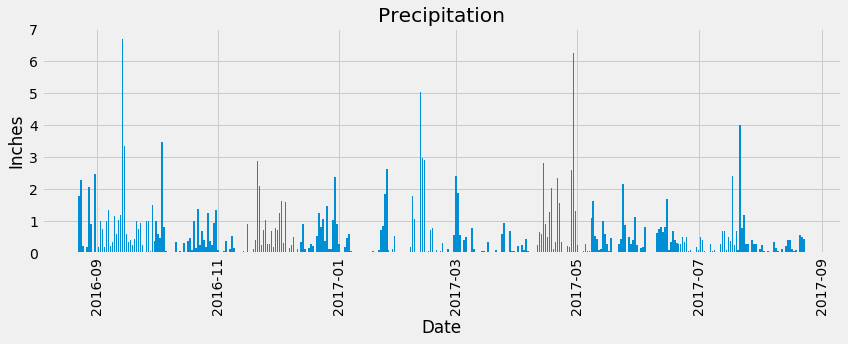

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(12,5))
plt.bar(prcp_df.index,prcp_df['prcp'])
plt.xticks(rotation=90)
plt.ylabel('Inches')
plt.xlabel('Date')
plt.title('Precipitation')
plt.tight_layout()
plt.savefig("images/precipitation.png")

In [14]:
# Save prcp_df as a csv file for use in app.py
prcp_df.reset_index().to_csv('precipitation.csv',index=False)
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
ustations = session.query(Measurement.station)
print(f"There are a total of {ustations.count()} stations")
print(f"There are {ustations.distinct().count()} unique stations")

There are a total of 19550 stations
There are 9 unique stations


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_freq = session.query(Measurement.station,func.count(Measurement.station)).\
                group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_freq

## References
# count and groupby -- https://stackoverflow.com/questions/1052148/group-by-count-function-in-sqlalchemy
# descending order -- https://stackoverflow.com/questions/4186062/sqlalchemy-order-by-descending

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = str(station_freq[0][0]) # grab the station id from previous query
mas_temp = session.query(Measurement.tobs).\
                        filter(Measurement.station == most_active_station).\
                        order_by(Measurement.tobs).all()
# convert tuple like element to float type
mas_temp = [float(x[0]) for x in mas_temp]
mas_max_temp = max(mas_temp) # or = mas_temp[-1] because of order_by in query
mas_min_temp = min(mas_temp) # or = mas_temp[0] because of order_by in query
mas_avg_temp = np.mean(mas_temp)
print(f"The minimum temp measured by station {most_active_station} is {mas_min_temp} in Fahrenheit")
print(f"The maximum temp measured by station {most_active_station} is {mas_max_temp} in Fahrenheit")
print(f"The average temp measured by station {most_active_station} is {mas_avg_temp:.1f} in Fahrenheit")

The minimum temp measured by station USC00519281 is 54.0 in Fahrenheit
The maximum temp measured by station USC00519281 is 85.0 in Fahrenheit
The average temp measured by station USC00519281 is 71.7 in Fahrenheit


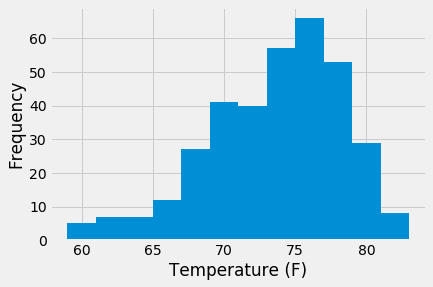

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_temp = session.query(Measurement.tobs,Measurement.date).\
                        filter(Measurement.station == most_active_station).\
                        filter(Measurement.date >= year_ago).all() # year_ago from the begining of notebook
last_year_temp_df = pd.DataFrame(last_year_temp)
plt.figure()
last_year_temp_df['tobs'].plot(kind='hist',bins=12)
plt.xlabel('Temperature (F)')
plt.savefig("images/tempFrequencyStation.png")

In [19]:
# Save for use in app.py
last_year_temp_df.to_csv('mas_tobs.csv',index=False)

## All Stations Temperature

In [20]:
# Temperature Analysis I
# perform query to find all temps from all stations in June and December for all years
june_temp = session.query(Measurement.tobs).\
            filter(func.strftime("%m", Measurement.date) == "06").all()
dec_temp = session.query(Measurement.tobs).\
            filter(func.strftime("%m", Measurement.date) == "12").all()
# convert tuple like element to float type
june_temp = [float(x[0]) for x in june_temp]
dec_temp = [float(x[0]) for x in dec_temp]

# Report averages
print(f"June Temp average: {np.mean(june_temp):.1f} +/- {np.std(june_temp):.1f}")
print(f"December Temp average: {np.mean(dec_temp):.1f} +/- {np.std(dec_temp):.1f}")

# t test analysis
tstat, pvalue = stats.ttest_ind(a=june_temp,b=dec_temp,equal_var=False)
print(f"T test results are t stat value: {tstat} and pvalue: {pvalue}")

June Temp average: 74.9 +/- 3.3
December Temp average: 71.0 +/- 3.7
T test results are t stat value: 31.355036920962423 and pvalue: 4.193529835915755e-187


With a pvalue much less than zero, we can reject the null hypothesis of the two sets having 
the same average and conclude that the difference between the two averages is significant. So while
the difference is significant, from a human comfort level, you could maybe see that the mean temp in 
December is still warm, and choose to go during that time. However, do note that the variance/STDev
for the temperatures in December is sligtly larger than in June.

Using the ttest_rel as the two datasets are unpaired. The two datasets are not exactily the
same. There are a different number of measurements taken in different months.
ttest_rel will tell us if the average changing as much as it does is significant
for something we are hypothesizing should be very similar. Then I have to set the equal_var=False as
the two datasets have different variances.

In [21]:
# Temperature Analysis II
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps_3 = calc_temps('2017-01-01','2018')
tmin, tavg, tmax = temps_3[0][0], temps_3[0][1], temps_3[0][2]
print(tmin,tavg,tmax)

58.0 74.14387974230493 87.0


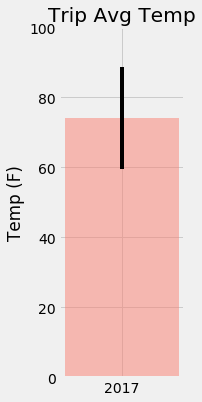

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2,6))
plt.bar("2017",tavg,yerr=(tmax-tmin)/2,color='salmon',alpha=0.5)
# plt.bar("2017",tavg,yerr=(tavg-tmin, tmax-tavg), color='salmon',alpha=0.5)
plt.grid(True)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.ylim(0,100)
plt.savefig("images/singleTempBar.png")

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

station_amount_q = session.query(Measurement.station, Station.name, func.sum(Measurement.prcp),
                              Station.latitude,Station.longitude,Station.elevation).\
                    group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).\
                    join(Station, Measurement.station==Station.station).all()
# station_amount_q
station_amount_list = [list(x) for x in station_amount_q]
amounts_df = pd.DataFrame(station_amount_list)
amounts_df = amounts_df.rename(columns={0:'Station ID',1:'Station Name',2:'prcp Sum',
                                        3:'latitude',4:'longitude',5:'elevation'})
amounts_df.to_csv('station_sum.csv',index=False)
amounts_df

,Station ID,Station Name,prcp Sum,latitude,longitude,elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",1068.09,21.33310,-157.80250,152.4
1,USC00519281,"WAIHEE 837.5, HI US",588.64,21.45167,-157.84889,32.9
2,USC00513117,"KANEOHE 838.1, HI US",382.62,21.42340,-157.80150,14.6
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",295.68,21.33556,-157.71139,19.5
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",234.49,21.52130,-157.83740,7.0
5,USC00519397,"WAIKIKI 717.2, HI US",131.62,21.27160,-157.81680,3.0
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",92.68,21.31520,-157.99920,0.9
7,USC00518838,"UPPER WAHIAWA 874.3, HI US",70.87,21.49920,-158.01110,306.6
8,USC00517948,"PEARL CITY, HI US",43.44,21.39340,-157.97510,11.9


In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# Create a function for easy looping through days and months
def str_that_date(m,d):
    """
    Args:
        m (int): input month as an integer
        d (int): input day as an integer
    Returns:
        A string of the date in apporopriate formating"""
    
    if m < 10:
        month = '0'+str(m)
    else:
        month = str(m)
    
    if d < 10:
        day = '0'+str(d)
    else:
        day = str(d)
        
    return (month+'-'+day)
str_that_date(2,9)

'02-09'

In [27]:
# loop through each day of each month and store in list
days_info = []
date_true = []
for m in range(1,12+1): # loop through all possible months (1-12)
    for d in range(1,31+1): # loop through all possible days (1-31)
        # calculate the daily normals for each day and append to list
        temp = daily_normals(str_that_date(m,d))
        if temp[0][0] != None: # filter out the days that didn't exists/have data for
            days_info.append(list(*temp))
            date_true.append(str_that_date(m,d))


In [28]:
# Store query into a dataframe, add the dates, and rename the columns
normal_df = pd.DataFrame(days_info)
normal_df['date'] = date_true
normal_df = normal_df.set_index('date')
normal_df = normal_df.rename(columns={0:"Min Temp",1:"Avg Temp",2:"Max Temp"})
# add a int style date for easy filtering
date_int = [int(x.replace('-','')) for x in date_true]
normal_df['INT Date'] = date_int

normal_df.head()

,Min Temp,Avg Temp,Max Temp,INT Date
date,,,,
01-01,62.0,69.153846,77.0,101
01-02,60.0,69.396226,77.0,102
01-03,62.0,68.909091,77.0,103
01-04,58.0,70.000000,76.0,104
01-05,56.0,67.964286,76.0,105


In [29]:
# Create function that takes trip dates and dataframe
# return a df with temperature for the date range desired
def weather_for_trip(start_month,start_day,end_month,end_day,big_df):
    """
    Args:
        start_month (int): input start month of trip as an integer
        start_day (int): input start day of trip as an integer
        end_month (int): input end month of trip as an integer
        end_day (int): input end day of trip as an integer
        big_df (pd.DataFrame): input dataframe with average values for each day
    Returns:
        A dataframe with temperature infor over duration of trip
    """
    temp_df = big_df.loc[(big_df['INT Date'] >= 
                            int(str_that_date(start_month,start_day).replace('-',''))),:]
    temp_df = temp_df.loc[(temp_df['INT Date'] <= 
                          int(str_that_date(end_month,end_day).replace('-',''))), :]
    temp_df = temp_df.drop(columns='INT Date')
    return temp_df

trip_df = weather_for_trip(6,15,7,2,normal_df)

trip_df.to_dict()

{'Min Temp': {'06-15': 67.0,
  '06-16': 69.0,
  '06-17': 68.0,
  '06-18': 69.0,
  '06-19': 70.0,
  '06-20': 68.0,
  '06-21': 68.0,
  '06-22': 69.0,
  '06-23': 68.0,
  '06-24': 68.0,
  '06-25': 68.0,
  '06-26': 67.0,
  '06-27': 66.0,
  '06-28': 69.0,
  '06-29': 67.0,
  '06-30': 67.0,
  '07-01': 67.0,
  '07-02': 68.0},
 'Avg Temp': {'06-15': 75.40350877192982,
  '06-16': 75.41379310344827,
  '06-17': 74.59322033898304,
  '06-18': 74.60344827586206,
  '06-19': 75.44067796610169,
  '06-20': 73.96491228070175,
  '06-21': 74.75862068965517,
  '06-22': 75.15789473684211,
  '06-23': 74.54385964912281,
  '06-24': 74.96428571428571,
  '06-25': 74.10344827586206,
  '06-26': 74.21428571428571,
  '06-27': 75.01785714285714,
  '06-28': 74.88679245283019,
  '06-29': 74.91525423728814,
  '06-30': 75.59615384615384,
  '07-01': 74.77777777777777,
  '07-02': 75.40384615384616},
 'Max Temp': {'06-15': 81.0,
  '06-16': 81.0,
  '06-17': 81.0,
  '06-18': 80.0,
  '06-19': 82.0,
  '06-20': 85.0,
  '06-21': 82.

<Figure size 864x360 with 0 Axes>

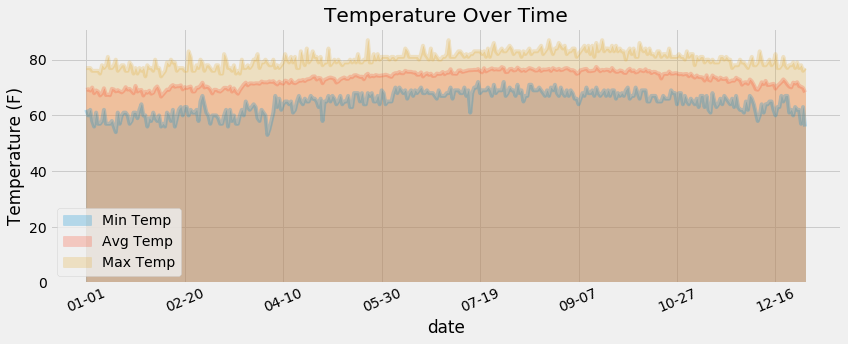

In [32]:
# Plot the temps for the entire year to match given image
# Plot the daily normals as an area plot with `stacked=False`
year_trip_df = weather_for_trip(1,1,12,31,normal_df)

# fig, ax = plt.subplots()
plt.figure(figsize=(12,5))
year_trip_df.plot(kind='area',stacked=False,alpha=0.25,rot=23,figsize=(12,5))
plt.title('Temperature Over Time')
plt.ylabel('Temperature (F)')
plt.tight_layout()
plt.savefig("images/allTemps.png")